Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/7998b8a481fccd467463deb1fc46d19622079b0e/LICENSE.md)




# Running Cortex Certifai Scan on Sklearn model built and deployed on AWS Sagemaker using Certifai Model Connectors


In this tutorial we will create sklearn models to classify german credit loan risk (predict whether loan will be granted or not). Models are built using Scikit-learn with [Sagemaker](https://sagemaker.readthedocs.io/en/stable/using_sklearn.html) by utilizing the pre-built container. Cortex Certifai provides first class support for various machine learning platforms including aws-sagemaker. We will then use [Cortex Certifai Toolkit](https://cognitivescale.github.io/cortex-certifai/) to launch fairness evaluation on the hosted models

### Prerequisites

This notebook was created and tested on an ml.m4.xlarge sagemaker notebook instance. However you can also run it locally by making sure you have the [aws profile](https://docs.aws.amazon.com/cli/latest/reference/configure/) configured and following dependencies installed on your system.

Creating a python environment with prerequisite dependencies is covered in part 1: [part_one_installing_dependencies.ipynb](./part_one_installing_dependencies.ipynb).

### First, lets create our Sagemaker session and role and create a S3 prefix to use for the notebook example.


#### [optional for local usage] sagemaker iam role guide setting up permissions (roles) for running this notebook locally
- follow the [sagemaker-iam-role-documentation](https://docs.aws.amazon.com/glue/latest/dg/create-an-iam-role-sagemaker-notebook.html) for creating an `iam-role`

> this notebook was built using iam-role `AmazonSageMakerFullAccess`

make sure `~/.aws/configure` looks like below


```
[default]
region = <aws-region>
output = <YAML>
role_arn = <aws_iam_role>
source_profile = default
```
and `~/.aws/credentials` has the necessary access and secret access keys

```
[default]
aws_access_key_id = <access_key_id>
aws_secret_access_key = <secret_access_key>
```

**PleaseNote**:  Once you have the execution role setup (using iam-role guide from above), you must enable `Trust Policy` which specifies who is allowed to assume the associated role. If this is missing you might get an **error 
user <user1\> unable to  STS AssumeRole**. Refer to [trust-policy-iam-role](https://aws.amazon.com/blogs/security/how-to-use-a-single-iam-user-to-easily-access-all-your-accounts-by-using-the-aws-cli/)

In [1]:
# S3 prefix
prefix = 'german-credit-certifai'

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.(set role in ~/.aws/config when running locally)
role = get_execution_role()

### Download german credit dataset from UCI 

- on macOS wget can be installed via homebrew `brew install wget`
- on windows download wget from [here](http://gnuwin32.sourceforge.net/packages/wget.htm)

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data -O german_credit.csv

--2023-01-26 16:55:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german_credit.csv’

german_credit.csv   100%[===================>]  77.92K  --.-KB/s    in 0.09s   

2023-01-26 16:55:05 (843 KB/s) - ‘german_credit.csv’ saved [79793/79793]



### Convert downloaded raw dataset to encoded csv

In [3]:
from decode_data import make_decoded_data
!mkdir -p ./data
make_decoded_data("data/german_credit-decoded.csv")

saving decoded data as data/german_credit-decoded.csv




### Test to confirm correct version of scikit-learn and numpy are installed


In [4]:
import sklearn as sklearn_version_test
import numpy as numpy_version_test
assert sklearn_version_test.__version__ == '1.0.1', 'scikit-learn version mismatch, `!pip install scikit-learn==1.0.1` paste this command in a cell to install right sklearn version for this notebook'
assert numpy_version_test.__version__   == '1.21.5', 'numpy version mismatch, `!pip install numpy==1.21.5` paste this command in a cell to install right numpy version for this notebook'

### Upload the encoded dataset to S3 for training 

In [5]:
WORK_DIRECTORY = 'data'
train_input = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

### Create a Scikit-learn script to train with 

SageMaker can run a scikit-learn script using the SKLearn estimator. When executed on SageMaker a number of environment variables are available to access properties of the training environment, such as:

- SM_MODEL_DIR: A string representing the path to the directory to write model artifacts to. Any artifacts saved in this folder are uploaded to S3 for model hosting after the training job completes.
-  SM_OUTPUT_DIR: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, 'train' and 'test', were used in the call to the SKLearn estimator's fit() method, the following environment variables will be set, following the format SM_CHANNEL_[channel_name]:

    SM_CHANNEL_TRAIN: A string representing the path to the directory containing data in the 'train' channel
    SM_CHANNEL_TEST: Same as above, but for the 'test' channel.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to script as arguments and can be retrieved with an argparse.ArgumentParser instance. For example, the script that we will run in this notebook is the below:

### Create encoder for the encoding categorical features

Note all extra modules and files must be in a directory to be uploaded to sagemaker. We create a directory name `source_dir` and add our files

In [6]:
!mkdir -p source_dir

In [7]:
%%writefile source_dir/cat_encoder.py

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np

class CatEncoder:
    def __init__(self, cat_columns, data, normalize: bool=True):
        self.cat_indexes = [data.columns.get_loc(name) for name in cat_columns]
        self.num_indexes = [idx for idx in range(len(data.columns)) if idx not in self.cat_indexes]
        self.encoder = preprocessing.OneHotEncoder()
        self.encoder.fit(data[cat_columns].values)
        self.num_columns = list(data.columns[self.num_indexes])
        self.cat_columns = cat_columns
        cat_transformed_names = self.encoder.get_feature_names_out(input_features=self.cat_columns)
        self._transformed_column_names =  self.num_columns + list(cat_transformed_names)
        if normalize:
            self.normalizer = StandardScaler()
            self.normalizer.fit(data.iloc[:, self.num_indexes].values)
        else:
            self.normalizer = None

    def __call__(self, x):
        numeric = x[:, self.num_indexes]
        if self.normalizer is not None:
            numeric = self.normalizer.transform(numeric)
        categorical = self.encoder.transform(x[:, self.cat_indexes]).toarray()
        return np.concatenate((numeric, categorical), axis=1)

    @property
    def transformed_features(self):
        return self._transformed_column_names


Overwriting source_dir/cat_encoder.py


### Create requirements.txt file for any training/inference specific python packages/versions

In [8]:
%%writefile source_dir/requirements.txt
scikit-learn==1.0.1
numpy==1.21.5

Overwriting source_dir/requirements.txt


### Create logistic model training and inference script

In [9]:
%%writefile source_dir/logistic_script.py

import argparse
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
import joblib
import numpy as np
from cat_encoder import CatEncoder
import json

# inference functions ---------------
def model_fn(model_dir):
    print(f'listing model dir {os.listdir(model_dir)}' )
    clf = joblib.load(os.path.join(model_dir,'german_credit_logit.joblib'))
    print(clf)
    return clf


def input_fn(request_body, request_content_type):
    """An input_fn that loads a json bytes string. 
    Certifai invokes model with the json schema -> {"payload": {"instances": [ [6,107,88,0,0,36.8,0.727,31], [5,100,80,0,0,31.9,0.61,33] ]}}
    """
    if request_content_type == "application/json":
        input_data  = json.loads(request_body).get('payload', {}).get('instances', [])
        data  = np.array(input_data, dtype=object)
        data  = data if data.ndim == 2 else np.reshape(data, (1, -1))
        return data
    else:
        raise Exception(f'content type {request_content_type} not supported')

def predict_fn(input_data, clf):
    """certifai expects model response with json
    schema -> {"payload": {"predictions": [1,0]} }
    """
    model = clf.get('model')
    encoder = clf.get('encoder')
    try:
        prediction = model.predict(encoder(input_data))
        print(prediction)
        return {"payload":{ "predictions": prediction.tolist()} }
    except Exception as e:
        return {"payload":{ "error": str(e)}}
                


if __name__ =='__main__':
    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--train-file', type=str, default='german_credit-decoded.csv')
    
    # hyperparams for training
    parser.add_argument('--max_iter', type=list,  default=[1000])
    parser.add_argument('--solver',   type=list,  default= ['lbfgs'])
    parser.add_argument('--C',        type=tuple, default=(0.5, 1.0, 2.0))

    args, _ = parser.parse_known_args()    
    
    print('reading data')
    df = pd.read_csv(os.path.join(args.train, args.train_file))
    cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

    label_column = 'outcome'
    y = df[label_column]
    X = df.drop(label_column, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    # apply categorical encoder to data     
    encoder = CatEncoder(cat_columns, X)
    
    parameters = {'C':args.C, 'solver':args.solver, 'max_iter':args.max_iter}
    
    m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(encoder(X_train.values), y_train)

    # Assess on the test data
    accuracy = model.score(encoder(X_test.values), y_test)
    print(f"Model accuracy is {accuracy}")
  
    # create artifact object with model and encoder
    model_path = os.path.join(args.model_dir, 'german_credit_logit')
    model_path = f'{model_path}.joblib'
    model_obj = {
        "model":model,
        "encoder":encoder
    }
    joblib.dump(value=model_obj, filename=model_path)
    print(f'model {model_obj} saved on disk as {model_path}')


Overwriting source_dir/logistic_script.py


### training logistic model locally

In [10]:
! python source_dir/logistic_script.py --model-dir ./ \
                   --train ./data \

extracting arguments
reading data
Model accuracy is 0.805
model {'model': GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': (0.5, 1.0, 2.0), 'max_iter': [1000],
                         'solver': ['lbfgs']}), 'encoder': <cat_encoder.CatEncoder object at 0x7fcb5031cb80>} saved on disk as ./german_credit_logit.joblib


### Create SageMaker Scikit Estimator for logistic model

To run our Scikit-learn training script on SageMaker, we construct a sagemaker.sklearn.estimator.sklearn estimator, which accepts several constructor arguments:

-    entry_point: The path to the Python script SageMaker runs for training and prediction.
-    role: Role ARN
-    instance_type (optional): The type of SageMaker instances for training. Note: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
-    sagemaker_session (optional): The session used to train on Sagemaker.
-    hyperparameters (optional): A dictionary passed to the train function as hyperparameters.


In [11]:
from sagemaker.sklearn.estimator import SKLearn

sklearn_logistic = SKLearn(
    entry_point='logistic_script.py',
    framework_version="1.0-1",
    py_version="py3",
    source_dir='source_dir',
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session
    )


### Train SKLearn logistic model Estimator on german credit encoded data uploaded to S3
Training is very simple, just call fit on the Estimator. This will start a SageMaker Training job that will download the data for us, invoke our scikit-learn code (in the provided script file inside the source_dir), and save any model artifacts that the script creates.

In [12]:
sklearn_logistic.fit({'train': train_input})

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2023-01-26-22-55-45-433


2023-01-26 22:55:46 Starting - Starting the training job...
2023-01-26 22:56:01 Starting - Preparing the instances for training......
2023-01-26 22:57:08 Downloading - Downloading input data...
2023-01-26 22:57:33 Training - Downloading the training image...
2023-01-26 22:58:19 Uploading - Uploading generated training model2023-01-26 22:58:08,148 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-01-26 22:58:08,150 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-26 22:58:08,159 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-01-26 22:58:08,339 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: numpy



2023-01-26 22:58:30 Completed - Training job completed
Training seconds: 82
Billable seconds: 82


### Similarly create svm model training and inference script

In [13]:
%%writefile source_dir/svm_script.py

import argparse
import os
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
import joblib
import numpy as np
from cat_encoder import CatEncoder
import json

# inference functions ---------------
def model_fn(model_dir):
    print(f'listing model dir {os.listdir(model_dir)}' )
    clf = joblib.load(os.path.join(model_dir,'german_credit_svm.joblib'))
    print(clf)
    return clf


def input_fn(request_body, request_content_type):
    """An input_fn that loads a json bytes string"""
    if request_content_type == "application/json":
        input_data  = json.loads(request_body).get('payload', {}).get('instances', [])
        data  = np.array(input_data, dtype=object)
        data  = data if data.ndim == 2 else np.reshape(data, (1, -1))
        return data
    else:
        raise Exception(f'content type {request_content_type} not supported')

def predict_fn(input_data, clf):
    model = clf.get('model')
    encoder = clf.get('encoder')
    try:
        prediction = model.predict(encoder(input_data))
        print(prediction)
        return {"payload":{ "predictions": prediction.tolist()} }
    except Exception as e:
        return {"payload":{ "error": str(e)}}
                


if __name__ =='__main__':
    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--train-file', type=str, default='german_credit-decoded.csv')
    
    # hyperparams for training
    parser.add_argument('--kernel', type=list,  default= ['linear', 'rbf', 'poly'])
    parser.add_argument('--gamma',  type=list,  default= ['auto'])
    parser.add_argument('--C',      type=list,  default= [0.1, .5, 1, 2, 4, 10])

    args, _ = parser.parse_known_args()    
    
    print('reading data')
    df = pd.read_csv(os.path.join(args.train, args.train_file))
    cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

    label_column = 'outcome'
    y = df[label_column]
    X = df.drop(label_column, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    # apply categorical encoder to data     
    encoder = CatEncoder(cat_columns, X)
        
    parameters={'kernel':args.kernel, 'C':args.C, 'gamma':args.gamma}
    m = svm.SVC()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(encoder(X_train.values), y_train)

    # Assess on the test data
    accuracy = model.score(encoder(X_test.values), y_test)
    print(f"Model accuracy is {accuracy}")
  
    # create artifact object with model and encoder
    model_path = os.path.join(args.model_dir, 'german_credit_svm')
    model_path = f'{model_path}.joblib'
    model_obj = {
        "model":model,
        "encoder":encoder
    }
    joblib.dump(value=model_obj, filename=model_path)
    print(f'model {model_obj} saved on disk as {model_path}')


Overwriting source_dir/svm_script.py


### training svm model locally

In [14]:
! python source_dir/svm_script.py --model-dir ./ \
                   --train ./data 

extracting arguments
reading data
Model accuracy is 0.81
model {'model': GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 2, 4, 10], 'gamma': ['auto'],
                         'kernel': ['linear', 'rbf', 'poly']}), 'encoder': <cat_encoder.CatEncoder object at 0x7fa432b31a30>} saved on disk as ./german_credit_svm.joblib


### Similarly create SageMaker Scikit Estimator for svm model

In [15]:
from sagemaker.sklearn.estimator import SKLearn

sklearn_svm = SKLearn(
    entry_point='svm_script.py',
    framework_version="1.0-1",
    py_version="py3",
    source_dir='source_dir',
    instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session
    )


### Train SKLearn svm model Estimator on german credit encoded data uploaded to S3


In [16]:
sklearn_svm.fit({'train': train_input})

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2023-01-26-23-05-51-530


2023-01-26 23:05:52 Starting - Starting the training job...
2023-01-26 23:06:09 Starting - Preparing the instances for training......
2023-01-26 23:07:18 Downloading - Downloading input data...
2023-01-26 23:07:44 Training - Downloading the training image...
2023-01-26 23:08:14 Training - Training image download completed. Training in progress..2023-01-26 23:08:22,190 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-01-26 23:08:22,192 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-26 23:08:22,201 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-01-26 23:08:22,378 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 46.7 MB/s eta 0:00:00
  Attemp


2023-01-26 23:08:45 Uploading - Uploading generated training model
2023-01-26 23:08:45 Completed - Training job completed
Training seconds: 87
Billable seconds: 87


### Using the trained model to make inference requests 

### Deploy the models

**Note:** this might take a few minutes

In [17]:
predictor_logistic = sklearn_logistic.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2023-01-26-23-09-12-998
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2023-01-26-23-09-12-998
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2023-01-26-23-09-12-998


--------!

In [18]:
predictor_svm      = sklearn_svm.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2023-01-26-23-13-17-098
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2023-01-26-23-13-17-098
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2023-01-26-23-13-17-098


-------!

### Test model predictions

In [19]:
import numpy as np
import json
idata = json.dumps({"payload":{
    "instances":[
            "... < 0 DM",
            6,
            "critical account/ other credits existing (not at this bank)",
            "radio/television",
            1169,
            "unknown/ no savings account",
            ".. >= 7 years",
            4,
            "male : single",
            "others - none",
            4,
            "real estate",
            "> 25 years",
            "none",
            "own",
            2,
            "skilled employee / official",
            1,
            "phone - yes, registered under the customers name",
            "foreign - yes"
        ]}})

import boto3
import botocore
import json
from botocore.exceptions import HTTPClientError
client=boto3.client('sagemaker-runtime')
try:
    resp = client.invoke_endpoint(EndpointName=predictor_logistic.endpoint_name,Body=idata)
    print(json.loads(resp['Body'].read()))
except botocore.exceptions.ClientError as error:
    print(error)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


{'payload': {'predictions': [1]}}


### Using Cortex Certifai python-package to launch a scan


In [20]:
from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue,
                                      CertifaiModelConnector, CertifaiModelMetric)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
import pandas as pd

### define cortex certifai task type

-    `CertifaiTaskOutcomes`: cortex certifai supports classification as well as regression models. here we have an example of binary-classification (e.g. predict whether loan should be granted or not)
-    `CertifaiOutcomeValue`: define the different outcomes possible from the model predictions. here we have a model that predicts either 1(loan granted) or 2(loan denied)

Note: Please refer to [Certifai API documentation](https://cognitivescale.github.io/cortex-certifai/docs/reference/api/) for more details


In [21]:
base_path = '.'
all_data_file = f"{base_path}/data/german_credit-decoded.csv"

In [22]:
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)


### add logistic and svm models sagemaker models deployed above


In [23]:
# Add the SageMaker model
sagemaker_connector = CertifaiModelConnector('sagemaker', 'certifai.connectors.sagemaker', 'SageMakerModel')
first_model = CertifaiModel('logit_sagemaker',
                            predict_endpoint=predictor_logistic.endpoint_name,
                            connector=sagemaker_connector)
scan.add_model(first_model)
second_model = CertifaiModel('svm_sagemaker',
                            predict_endpoint=predictor_svm.endpoint_name,
                            connector=sagemaker_connector)
scan.add_model(second_model)


### add the evaluation dataset to scan object

-    evaluation dataset dataset to be used by cortex certifai to evaluate the model against



In [24]:
# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)

### evaluating model fairness

-   add fairness as evaluation type to scan object
-   create an evaluation_dataset_id to refer to added evaluation datset

In [25]:
# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'

In [26]:
# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

In [27]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)

2023-01-26 17:48:08,756 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest included class size is for status='male : divorced/separated' with 50 samples)


Starting scan with model_use_case_id: 'test_user_case' and scan_id: '9041125c239e'
[--------------------] 2023-01-26 17:48:08.742659 - 0 of 4 reports (0.0% complete) - Running fairness evaluation for model: logit_sagemaker


2023-01-26 17:49:57,423 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2023-01-26 17:50:35,060 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2023-01-26 17:53:20,791 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples
2023-01-26 17:53:32,435 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest included class size is for status='male : divorced/separated' with 50 samples)


[#####---------------] 2023-01-26 17:53:32.424262 - 1 of 4 reports (25.0% complete) - Running atx evaluation for model: logit_sagemaker
[##########----------] 2023-01-26 17:53:32.426023 - 2 of 4 reports (50.0% complete) - Running fairness evaluation for model: svm_sagemaker


2023-01-26 17:55:28,112 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2023-01-26 17:56:41,145 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2023-01-26 17:59:03,719 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2023-01-26 17:59:54,675 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 547 samples


[###############-----] 2023-01-26 18:00:06.644689 - 3 of 4 reports (75.0% complete) - Running atx evaluation for model: svm_sagemaker
[####################] 2023-01-26 18:00:06.646506 - 4 of 4 reports (100.0% complete) - Completed all evaluations



### Analayze Fairness Results


In [28]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible
df = construct_scores_dataframe(scores('fairness', result), include_confidence=False)
display(df)

,context,type,fairness,Feature (age),type in Feature (age),Group details (> 25 years),Feature (status),type in Feature (status),Group details (female : divorced/separated/married),type in Feature (status),Group details (male : divorced/separated),type in Feature (status),Group details (male : married/widowed),type in Feature (status),Group details (male : single)
logit_sagemaker (burden),logit_sagemaker,burden,75.071514,100.0,burden,0.047637,75.071514,burden,0.068124,burden,0.070537,burden,0.032703,burden,0.037751
svm_sagemaker (burden),svm_sagemaker,burden,75.823732,100.0,burden,0.049834,75.823732,burden,0.065710,burden,0.072222,burden,0.031410,burden,0.041917



### fairness by model


,context,type,fairness,Feature (age),Feature (age) lower bound,Feature (age) upper bound,type in Feature (age),Group details (> 25 years),Group details (> 25 years) lower bound,Group details (> 25 years) upper bound,...,Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,type in Feature (status),Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,type in Feature (status),Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
logit_sagemaker (burden),logit_sagemaker,burden,75.071514,100.0,100.0,100.0,burden,0.047637,0.042654,0.052836,...,0.046882,0.097331,burden,0.032703,0.021300,0.046270,burden,0.037751,0.031798,0.043999
svm_sagemaker (burden),svm_sagemaker,burden,75.823732,100.0,100.0,100.0,burden,0.049834,0.044892,0.055532,...,0.046970,0.099371,burden,0.031410,0.019919,0.044309,burden,0.041917,0.035471,0.049061


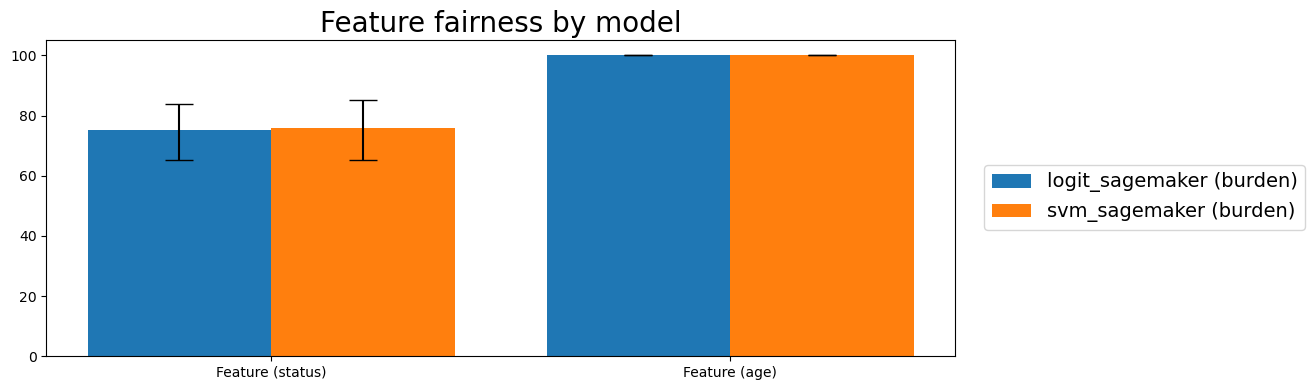

In [29]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))
display(df)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### Endpoint cleanup

delete the containers created after evaluation is complete

In [30]:
sklearn_svm.delete_endpoint()
sklearn_logistic.delete_endpoint()